#  <h3 align="center"><font color='#144272' size=6>Association Rule Based Recommender System</font></h3>

# <div align="center">
<img src="https://miro.medium.com/v2/resize:fit:980/1*WzlhttgnH7PBuxUcnO-ciw.jpeg" width="500" align="center"/>
</div>

###  <font color='#1C82AD' size=5>What is it?</font>

<font color='#13005A'>An association rule-based recommender system is a type of recommender system that utilizes association rules to suggest items to users. It is based on the concept that there are certain patterns or relationships between items that can be identified and used to predict which items a user might be interested in.<br><br>The system works by analyzing user behavior and identifying frequent itemsets, which are sets of items that are often purchased or viewed together. These itemsets are then used to generate association rules, which express the likelihood of a user purchasing one item given that they have purchased another item. When a user requests recommendations, the system looks for items that are associated with the items the user has already purchased or viewed. It then suggests the most likely items based on the association rules it has generated.<br><br>Association rule-based recommender systems are particularly effective for recommending items that are frequently purchased together, such as groceries or books. However, they may not work as well for recommending items that are less frequently purchased or for users with unique or unpredictable preferences.</font>

###  <font color='#1C82AD' size=5>Apriori Algorithm</font>

<font color='#13005A'>Apriori is an algorithm used in data mining and machine learning to identify frequent itemsets in a dataset. It is a key component of association rule-based recommender systems.<br><br> The Apriori algorithm works by scanning a dataset and identifying itemsets that occur frequently above a certain threshold (known as the support threshold). The algorithm then uses these frequent itemsets to generate association rules.<br><br> There are 3 significant metrics in Apriori:
</font>

<li>Support: Measures how often products X and Y are purchased together</li>

<div align="left"><img src="support.png" width="500" align="left"/></div>

<li>Confidence: Measures how often products X and Y are purchased together</li>

<div align="left"><img src="confidence.png" width="500" align="left"/></div>

<li>Lift: The coefficient of increase in the probability of purchasing product Y when product X is purchased.</li>

<div align="left"><img src="lift.png" width="500" align="left"/></div>

###  <font color='#1C82AD' size=5>Import Packages and Libraries</font>

In [15]:
# !pip install mlxtend
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

###  <font color='#1C82AD' size=5>Load Data</font>

In [3]:
df_ = pd.read_excel("online_retail_II.xlsx",
                    sheet_name="Year 2010-2011")
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


###  <font color='#1C82AD' size=5>Information About the Dataset</font>

In [31]:
def check_df(dataframe, head=5):
    print(" COLUMNS ".center(80, "-"))
    print(dataframe.columns)
    print(" TYPES ".center(80, "-"))
    print(dataframe.dtypes)
    print(" HEAD ".center(80, "-"))
    print(dataframe.head(head))
    print(" TAIL ".center(80, "-"))
    print(dataframe.tail(head))
    print(" INFO ".center(80, "-"))
    print(dataframe.info())
    print(" MISSING VALUES ".center(80, "-"))
    print(dataframe.isnull().sum())
    print(" QUANTILES ".center(80, "-"))
    print(dataframe.describe([0,0.05, 0.25, 0.50, 0.75, 0.95,0.99,1]).T)
    
check_df(df)  

----------------------------------- COLUMNS ------------------------------------
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
------------------------------------ TYPES -------------------------------------
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
------------------------------------- HEAD -------------------------------------
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84

###  <font color='#1C82AD' size=5>Data Manipulation</font>

In [65]:
def retail_data_prep(dataframe):
    # Drop null values
    dataframe.dropna(inplace=True)
    # Some of the invoice values starts with 'C', this represent the values that returned. So we don't need these in our project 
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    # Extracting if quantity or price have negative values
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    return dataframe

df = retail_data_prep(df)

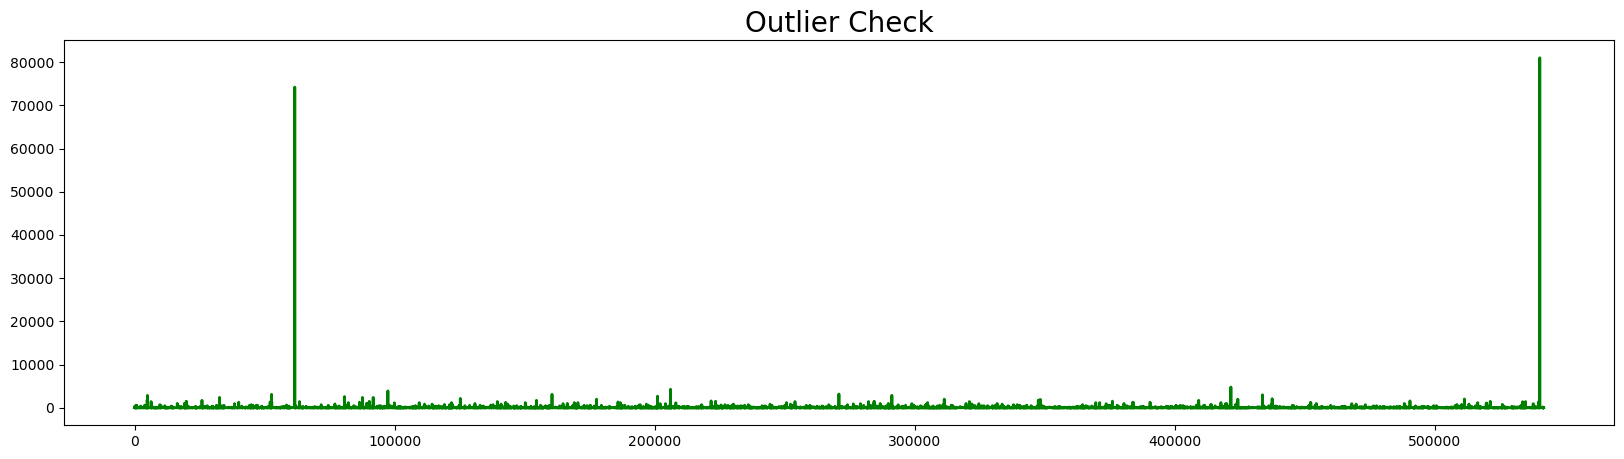

In [52]:
# Outlier check
def plot_outlier(dataframe, title):
    
    plt.figure(figsize=(20, 5))
    plt.plot(df['Quantity'], color='green', linewidth=2, label='control')
    plt.title(title, fontsize=20)
    plt.show()
    
plot_outlier(df, 'Outlier Check')   

In [66]:
# # Replacing outliers with the low and up limits
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, 'Quantity')
replace_with_thresholds(df, 'Price')

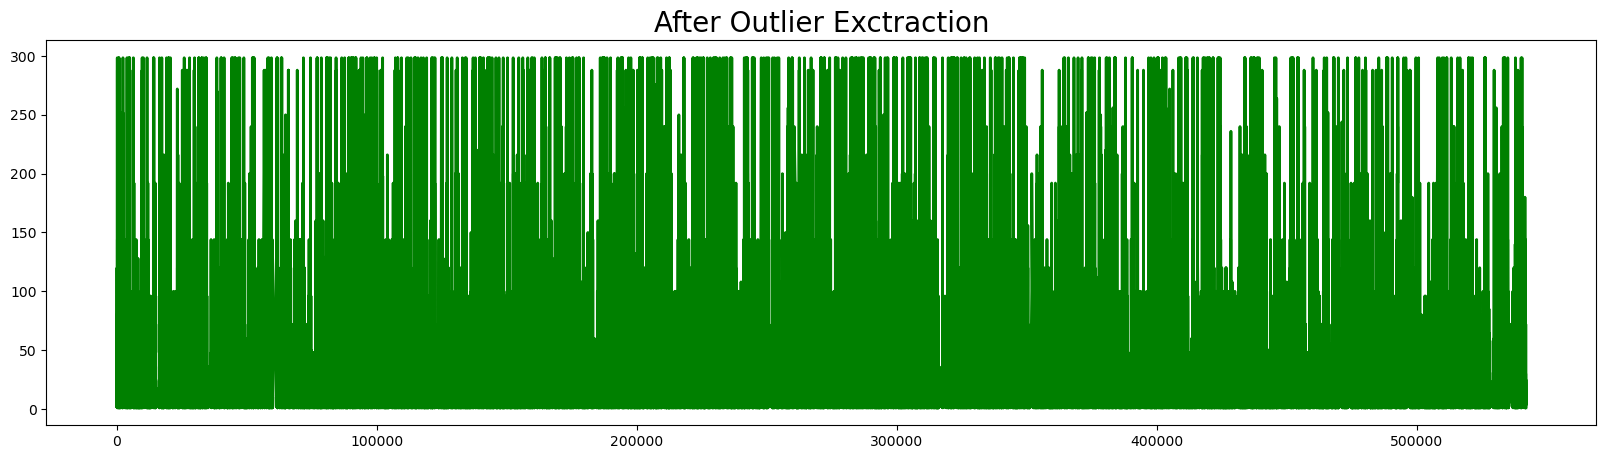

In [54]:
def plot_outlier(dataframe, title):
    
    plt.figure(figsize=(20, 5))
    plt.plot(df['Quantity'], color='green', linewidth=2, label='control')
    plt.title(title, fontsize=20)
    plt.show()
    
plot_outlier(df, 'After Outlier Exctraction')   

###  <font color='#1C82AD' size=5>Invoice - Product Matrix</font>

In [67]:
# Let's remove needless stock code value 'POST'
df = df[~df["StockCode"].str.contains("POST", na=False)]
# Selecting values that country is France
df_fr = df[df['Country'] == "France"]

# Quantity of each product that was sold in a given invoice. 
df_fr.groupby(['Invoice', 'Description']).agg({"Quantity": "sum"}).head(10)

Quantity
Invoice Description                               
536370   SET 2 TEA TOWELS I LOVE LONDON       24.0
        ALARM CLOCK BAKELIKE GREEN            12.0
        ALARM CLOCK BAKELIKE PINK             24.0
        ALARM CLOCK BAKELIKE RED              24.0
        CHARLOTTE BAG DOLLY GIRL DESIGN       20.0
        CIRCUS PARADE LUNCH BOX               24.0
        INFLATABLE POLITICAL GLOBE            48.0
        LUNCH BOX I LOVE LONDON               24.0
        MINI JIGSAW CIRCUS PARADE             24.0
        MINI JIGSAW SPACEBOY                  24.0

In [68]:
df_fr.groupby(['Invoice', 'Description']).agg({"Quantity": "sum"}).unstack().iloc[0:5, 0:5]

Quantity                     \
Description  50'S CHRISTMAS GIFT BAG LARGE  DOLLY GIRL BEAKER   
Invoice                                                         
536370                                 NaN                NaN   
536852                                 NaN                NaN   
536974                                 NaN                NaN   
537065                                 NaN                NaN   
537463                                 NaN                NaN   

                                                                   \
Description  I LOVE LONDON MINI BACKPACK  NINE DRAWER OFFICE TIDY   
Invoice                                                             
536370                               NaN                      NaN   
536852                               NaN                      NaN   
536974                               NaN                      NaN   
537065                               NaN                      NaN   
537463                               NaN                      NaN   

                                              
Description  SET 2 TEA TOWELS I LOVE LONDON   
Invoice                                       
536370                                  24.0  
536852                                   NaN  
536974                                   NaN  
537065                                   NaN  
537463                                   NaN

In [69]:
# We're simply making a basket and representing whether it was purchased or not with binary numbers
fr_inv_pro_df = df_fr.groupby(['Invoice', "StockCode"])['Quantity'].sum().unstack().fillna(0). \
    applymap(lambda x: 1 if x > 0 else 0)
fr_inv_pro_df

StockCode  10002  10120  10125  10135  11001  15036  15039  16012  16048  \
Invoice                                                                    
536370         1      0      0      0      0      0      0      0      0   
536852         0      0      0      0      0      0      0      0      0   
536974         0      0      0      0      0      0      0      0      0   
537065         0      0      0      0      0      0      0      0      0   
537463         0      0      0      0      0      0      0      0      0   
...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
580986         0      0      0      0      0      0      0      0      0   
581001         0      0      0      0      0      0      0      0      0   
581171         0      0      0      0      0      0      0      0      0   
581279         0      0      0      0      0      0      0      0      0   
581587         0      0      0      0      0      0      0      0      0   

StockCode  16218  16219  16225  16236  16237  16238  17174  20615  20617  \
Invoice                                                                    
536370         0      0      0      0      0      0      0      0      0   
536852         0      0      0      0      0      0      0      0      0   
536974         0      0      0      0      0      0      0      0      0   
537065         0      0      0      0      0      1      0      0      0   
537463         0      0      0      0      0      0      0      0      0   
...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
580986         0      0      0      0      0      0      0      0      0   
581001         0      0      0      0      0      0      0      0      0   
581171         0      0      0      0      0      0      0      0      0   
581279         0      0      0      0      0      0      0      0      0   
581587         0      0      0      0      0      0      0      0      0   

StockCode  20658  20665  20668  20674  20675  20676  20677  20679  20681  \
Invoice                                                                    
536370         0      0      0      0      0      0      0      0      0   
536852         0      0      0      0      0      0      0      0      0   
536974         0      0      0      0      0      0      0      1      0   
537065         0      1      0      0      0      0      0      0      0   
537463         0      0      0      0      0      0      0      0      1   
...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
580986         0      0      0      0      0      0      0      0      0   
581001         0      0      0      0      0      0      0      0      0   
581171         0      0      0      0      0      0      0      0      0   
581279         0      0      0      0      0      0      0      0      0   
581587         0      0      0      0      0      0      0      0      0   

StockCode  20682  20684  20685  20686  20702  20704  20711  20712  20713  \
Invoice                                                                    
536370         0      0      0      0      0      0      0      0      0   
536852         0      0      0      0      0      0      0      0      0   
536974         0      0      0      0      0      0      0      0      0   
537065         0      0      0      0      0      0      0      0      0   
537463         1      0      0      0      0      0      0      0      0   
...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
580986         0      0      0      0      0      0      0      0      0   
581001         0      0      0      0      0      0      0      0      0   
581171         1      0      0      0      0      0      0      0      0   
581279         0      0      0      0      0      0      0      0      0   
581587         0      0      0      0      0      0      0      0      0   

StockCode  20717  20718  20719  20723  20724

In [90]:
# A function tells us the product name of the given stock code
def check_id(dataframe, stock_code):
    product_name = dataframe[dataframe["StockCode"] == stock_code][["Description"]].values[0].tolist()
    return product_name[0]
    
check_id(df_fr, 10120)

'DOGGY RUBBER'

###  <font color='#1C82AD' size=5>Association Rules</font>

In [71]:
# Frequent itemsets are subsets of items that appear together frequently in a dataset.
frequent_itemsets = apriori(fr_inv_pro_df,
                            min_support=0.01,
                            use_colnames=True)

frequent_itemsets.sort_values("support", ascending=False).head()

,support,itemsets
387,0.190104,(23084)
107,0.182292,(21731)
243,0.174479,(22554)
245,0.171875,(22556)
185,0.161458,(22326)


In [72]:
# This code generates association rules from a set of frequent itemsets using the association_rules() function
# The support metric is being used, and the minimum threshold is set to 0.01
rules = association_rules(frequent_itemsets,
                          metric="support",
                          min_threshold=0.01)

rules.sort_values("support", ascending=False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1703,(21094),(21086),0.130208,0.140625,0.125000,0.960000,6.826667,0.106689,21.484375
1702,(21086),(21094),0.140625,0.130208,0.125000,0.888889,6.826667,0.106689,7.828125
6009,(22551),(22554),0.138021,0.174479,0.106771,0.773585,4.433681,0.082689,3.646050
6008,(22554),(22551),0.174479,0.138021,0.106771,0.611940,4.433681,0.082689,2.221254
1539,(21094),(21080),0.130208,0.135417,0.104167,0.800000,5.907692,0.086534,4.322917


In [74]:
rules[(rules["support"]>0.05) & (rules["confidence"]>0.1) & (rules["lift"]>5)]. \
sort_values("confidence", ascending=False).head(15)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
19740,"(21080, 21086)",(21094),0.104167,0.130208,0.101562,0.975000,7.488000,0.087999,34.791667
19741,"(21080, 21094)",(21086),0.104167,0.140625,0.101562,0.975000,6.933333,0.086914,34.375000
1703,(21094),(21086),0.130208,0.140625,0.125000,0.960000,6.826667,0.106689,21.484375
8348,(23256),(23254),0.070312,0.072917,0.065104,0.925926,12.698413,0.059977,12.515625
3589,(21988),(21987),0.057292,0.065104,0.052083,0.909091,13.963636,0.048353,10.283854
8349,(23254),(23256),0.072917,0.070312,0.065104,0.892857,12.698413,0.059977,8.677083
1702,(21086),(21094),0.140625,0.130208,0.125000,0.888889,6.826667,0.106689,7.828125
49086,"(22728, 22726)",(22727),0.075521,0.096354,0.065104,0.862069,8.946878,0.057827,6.551432
49087,"(22728, 22727)",(22726),0.075521,0.098958,0.065104,0.862069,8.711434,0.057631,6.532552
7347,(22727),(22726),0.096354,0.098958,0.080729,0.837838,8.466572,0.071194,5.556424


<div align="left"><img src="desc.png" width="700" align="left"/></div>

<font>After the rule table is created, sorting can be made according to the need (Support, Confidence, Lift, Leverage) and then the recommendation process can be performed.</font>

###  <font color='#1C82AD' size=5>Recommendation</font>

In [77]:
# Example
product_id = 22492
check_id(df, product_id)

['MINI PAINT SET VINTAGE ']


In [97]:
# This function recommends products that are frequently purchased together with a given product,
# based on the confidence of the association rule.

def arl_recommender(rules_df, product_id, rec_count=1):
    sorted_rules = rules_df.sort_values("confidence", ascending=False)
    recommendation_list = []
    for i, product in enumerate(sorted_rules["antecedents"]):
        for j in list(product):
            if j == product_id:
                recommendation_list.append(list(sorted_rules.iloc[i]["consequents"])[0])

    return recommendation_list[0:rec_count]

# Recommend 1 product
arl_recommender(rules, 22492, 3)

[22728, 22726, 22728]

In [101]:
recommendation_list = arl_recommender(rules, 22492, 2)
for name in recommendation_list:
    print(check_id(df_fr, name))

ALARM CLOCK BAKELIKE PINK
ALARM CLOCK BAKELIKE GREEN


 #### We recommended 2 products for the product with product id of 22492.